In [1]:
import pandas as pd
from datetime import datetime

df=pd.read_csv("Customer_Summary.csv")

In [2]:
ref_date=pd.to_datetime(df['LastPurchase']).max()+pd.Timedelta(days=1)
ref_date

Timestamp('2011-12-10 00:00:00')

In [3]:
df['Recency']=(ref_date-pd.to_datetime(df['LastPurchase'])).dt.days
df['Frequency']=df['TotalOrder']
df['Monetary']=df['TotalSpend']

### RFM Variable Assignment

The customer summary already includes TotalOrder and TotalSpend, which correspond to Frequency and Monetary in the RFM framework.  

To align with the standard RFM naming convention, I duplicated these columns:
- TotalOrder → Frequency
- TotalSpend → Monetary

This approach ensures consistency with common RFM analysis practices while keeping the original columns intact for flexibility or potential future adjustments.

In [4]:
rfm=df[['CustomerID','Recency','Frequency','Monetary']].copy()

In [5]:
rfm['R_Score']=pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score']=pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score']=pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score']=rfm['R_Score'].astype(str)+rfm['F_Score'].astype(str)+rfm['M_Score'].astype(str)


In [6]:
def segment_customer(df):
    seg_map = {
        r'555': 'Champions',
        r'5[4-5][4-5]': 'Loyal Customers',
        r'[3-4][3-5][3-5]': 'Potential Loyalist',
        r'[1-2][4-5][4-5]': 'At Risk',
        r'[1-2][1-2][1-2]': 'Lost',
        r'[3-5][1-2][1-2]': 'Need Attention',
        r'4[1-3][1-3]': 'Promising',
        r'[1-2][3-4][1-3]': 'Hibernating',
        r'[3-5]11': 'About to Sleep',
        r'5[1-3][1-3]': 'New Customers'
    }

    def map_segment(score):
        for pattern, segment in seg_map.items():
            if pd.Series(score).str.match(pattern).any():
                return segment
        return 'Others'

    df['Segment'] = df['RFM_Score'].apply(map_segment)
    return df

In [7]:
rfm=segment_customer(rfm)

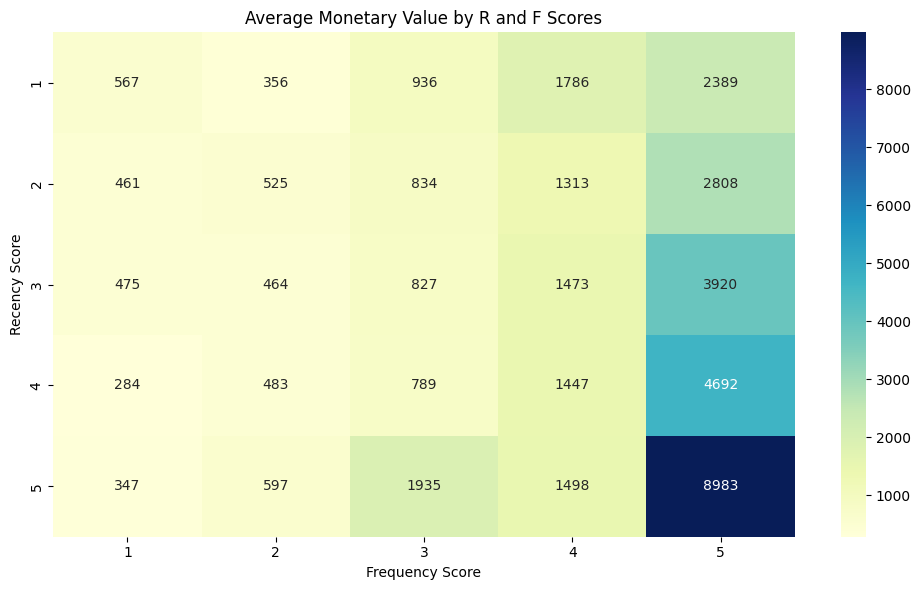

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm_heatmap = rfm.groupby(['R_Score', 'F_Score'])['Monetary'].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(rfm_heatmap, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Average Monetary Value by R and F Scores')
plt.ylabel('Recency Score')
plt.xlabel('Frequency Score')
plt.tight_layout()
plt.show()

In [9]:
rfm['Segment'].value_counts()

Segment
Potential Loyalist    995
Lost                  830
Others                691
Need Attention        482
Hibernating           373
Champions             354
Loyal Customers       219
At Risk               173
New Customers         122
Promising              92
Name: count, dtype: int64

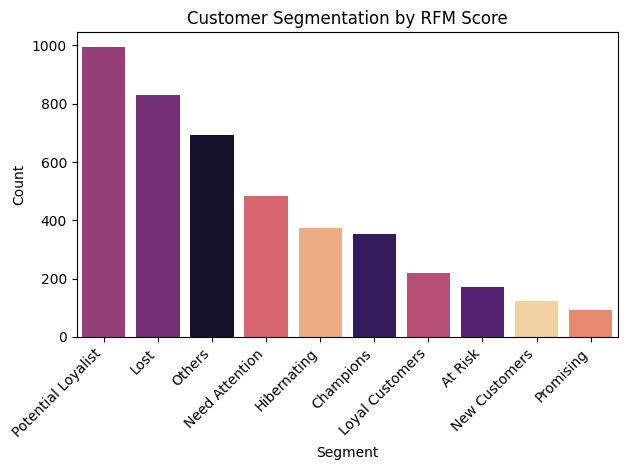

In [10]:
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index,palette='magma',hue='Segment',legend=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Customer Segmentation by RFM Score')
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

In [11]:
rfm.to_csv('RFM_Segmented.csv',index=False)